In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U discord.py
!pip install aitextgen
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 786 kB 2.1 MB/s 
     |████████████████████████████████| 1.3 MB 91.7 MB/s 
  Attempting uninstall: async-timeout
    Found existing installation: async-timeout 4.0.2
    Uninstalling async-timeout-4.0.2:
      Successfully uninstalled async-timeout-4.0.2
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.8.1
    Uninstalling aiohttp-3.8.1:
      Successfully uninstalled aiohttp-3.8.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 572 kB 2.0 MB/s 
     |████████████████████████████████| 4.9 MB 61.1 MB/s 
     |████████████████████████████████| 87 kB 9.1 MB/s 
     |████████████████████████████████| 708 kB 64.8 MB/s 
     |████████████████████████████████| 5.9 MB 48.9 MB/s 
     |████████████████████████████████| 419 kB 73.2 MB/s 
     |

In [ ]:
%cd /content/drive/MyDrive/joseph_yun/discord_bot

/content/drive/MyDrive/joseph_yun/discord_bot


In [ ]:
#!wget https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz
#!tar -xf empatheticdialogues.tar.gz

--2022-08-03 21:28:14--  https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28022709 (27M) [application/gzip]
Saving to: ‘empatheticdialogues.tar.gz.1’

empatheticdialogues 100%[===================>]  26.72M  29.6MB/s    in 0.9s    

2022-08-03 21:28:15 (29.6 MB/s) - ‘empatheticdialogues.tar.gz.1’ saved [28022709/28022709]



# AITextGen Portion

In [ ]:
import logging
logging.basicConfig(
        format="%(asctime)s — %(levelname)s — %(name)s — %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO
    )
from aitextgen import aitextgen
from aitextgen.colab import mount_gdrive, copy_file_from_gdrive
import pandas as pd
from aitextgen.TokenDataset import TokenDataset
import os
!python3 -m nltk.downloader stopwords
import nltk
from nltk.corpus import stopwords
import openai
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/joseph_yun/discord_bot/empatheticdialogues/train.csv", nrows=70000)
data.tail()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags,Unnamed: 8,Unnamed: 9,Unnamed: 10
69995,hit:11360_conv:22721,3,impressed,My son scored 2 goals in the football game. i ...,653,Oh yes I was. He does well in school as well.,2|2|2_3|5|5,NaN,NaN,NaN,NaN
69996,hit:11360_conv:22721,4,impressed,My son scored 2 goals in the football game. i ...,644,Good grades_comma_ good athletics_comma_ he so...,2|2|2_3|5|5,NaN,NaN,NaN,NaN
69997,hit:11360_conv:22721,5,impressed,My son scored 2 goals in the football game. i ...,653,I do hope so_comma_ he is a star.,2|2|2_3|5|5,NaN,NaN,NaN,NaN
69998,hit:11361_conv:22722,1,grateful,One time a lady just randomly paid for my coff...,557,Once a lady just randomly paid for my coffee a...,5|5|5_5|5|5,NaN,NaN,NaN,NaN
69999,hit:11361_conv:22722,2,grateful,One time a lady just randomly paid for my coff...,814,Oh that's awesome_comma_ Was she paying it for...,5|5|5_5|5|5,NaN,NaN,NaN,NaN


## SKLearn Portion

In [ ]:
def complex_to_basic(emotion):
  if emotion in ['proud', 'faithful', 'joyful', 'grateful', 'prepared', 'excited', 'confident', 'caring', 'trusting', 'anticipating', 'content', 'impressed']:
    return 'happy'
  elif emotion in ['afraid', 'terrified', 'anxious', 'apprehensive']:
    return 'fearful'
  elif emotion in ['sentimental', 'sad', 'lonely', 'ashamed', 'nostalgic', 'disappointed', 'devastated', 'embarrassed']:
    return 'sad'
  elif emotion in ['angry', 'jealous', 'annoyed', 'furious']:
    return 'angry'
  elif emotion in ['surprised']:
    return 'surprised'
  elif emotion in ['guilty', 'disgusted']:
    return 'disgust'
  elif emotion in ['hopeful']:
    return 'hopeful'
  else:
    return 'unknown'

In [ ]:
data.tail()
len(data.context.unique())
data.context.unique()

array(['sentimental', 'afraid', 'proud', 'faithful', 'terrified',
       'joyful', 'angry', 'sad', 'jealous', 'grateful', 'prepared',
       'embarrassed', 'excited', 'annoyed', 'lonely', 'ashamed', 'guilty',
       'surprised', 'nostalgic', 'confident', 'furious', 'disappointed',
       'caring', 'trusting', 'disgusted', 'anticipating', 'anxious',
       'hopeful', 'content', 'impressed', 'apprehensive', 'devastated'],
      dtype=object)

In [ ]:
basic_emotion = data.context.apply(complex_to_basic)

In [ ]:
data['basic_emotion'] = basic_emotion

In [ ]:
data.drop(["conv_id",	"utterance_idx", "speaker_idx", "selfeval", "tags", "Unnamed: 8", "Unnamed: 9", "Unnamed: 10"], axis=1, inplace=True)
data.head()

,context,prompt,utterance,basic_emotion
0,sentimental,I remember going to the fireworks with my best...,I remember going to see the fireworks with my ...,sad
1,sentimental,I remember going to the fireworks with my best...,Was this a friend you were in love with_comma_...,sad
2,sentimental,I remember going to the fireworks with my best...,This was a best friend. I miss her.,sad
3,sentimental,I remember going to the fireworks with my best...,Where has she gone?,sad
4,sentimental,I remember going to the fireworks with my best...,We no longer talk.,sad


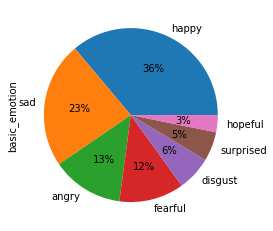

In [ ]:
data.basic_emotion.value_counts().plot(kind='pie', autopct='%1.0f%%')

In [ ]:
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(data['prompt']).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processed_features, data['basic_emotion'], test_size=0.2, random_state=0)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(processed_features, data['context'], test_size=0.2, random_state=0)

In [ ]:
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [ ]:
predictions = text_classifier.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[1864    3    0   11    0    6    0]
 [   5  864    0   14    0   10    0]
 [   0    0 1613    7    2    4    0]
 [   2    1    2 5079    1    5    1]
 [   0    0    4    7  445    0    0]
 [  10    5    0   15    0 3275    0]
 [   4    3    0    3    0    0  735]]
              precision    recall  f1-score   support

       angry       0.99      0.99      0.99      1884
     disgust       0.99      0.97      0.98       893
     fearful       1.00      0.99      0.99      1626
       happy       0.99      1.00      0.99      5091
     hopeful       0.99      0.98      0.98       456
         sad       0.99      0.99      0.99      3305
   surprised       1.00      0.99      0.99       745

    accuracy                           0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000

0.9910714285714286


In [ ]:
prompt=vectorizer.transform(['I anticipate it will rain today'])
answer=text_classifier.predict(prompt)
print(answer)

['happy']


In [ ]:
# save the model to disk
#%cd /content/drive/MyDrive/joseph_yun/discord_bot
#filename = './model.sav'
#pickle.dump(text_classifier, open(filename, 'wb'))
#vectorizer_filename = "./vectorizer.sav"
#pickle.dump(vectorizer, open(vectorizer_filename, 'wb'))

/content/drive/.shortcut-targets-by-id/1ORrCOg9R6nN2UtPS3nRHQJTxH2ioSt7J/joseph_yun/discord_bot


## OpenAI Section

In [ ]:
%cd /content/drive/MyDrive/joseph_yun/discord_bot
filename = './model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
vectorizer_filename = "./vectorizer.sav"
loaded_vectorizer = pickle.load(open(vectorizer_filename, 'rb'))

/content/drive/.shortcut-targets-by-id/1ORrCOg9R6nN2UtPS3nRHQJTxH2ioSt7J/joseph_yun/discord_bot


In [ ]:
user_prompt ="I hope it does not rain much"
prompt = loaded_vectorizer.transform([user_prompt])
sentiment=loaded_model.predict(prompt)
print(sentiment[0])

prompt = "Write some advice for someone that is feeling " + sentiment + " and tells you: " + user_prompt
prompt = prompt[0]
prompt

hopeful


'Write some advice for someone that is feeling hopeful and tells you: I hope it does not rain much'

In [ ]:
openai.organization = ""
openai.api_key = ""
openai.Model.list()

response = openai.Completion.create(
  engine="text-curie-001",
  prompt=prompt,
  temperature=0.5,
  max_tokens=256,
  top_p=1.0,
  frequency_penalty=0.0,
  presence_penalty=0.0
)

In [ ]:
print("Prompt: " + prompt)
print(response['choices'][0]['text'])

Prompt: Write some advice for someone that is feeling hopeful and tells you: I want to be a doctor one day


If you want to be a doctor, you have to be passionate about it and have a lot of dedication. You have to be willing to work hard and be disciplined. You also have to be able to handle stress and be able to deal with difficult patients.


In [ ]:
%cd /content/drive/MyDrive/joseph_yun/discord_bot
filename = './model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
vectorizer_filename = "./vectorizer.sav"
loaded_vectorizer = pickle.load(open(vectorizer_filename, 'rb'))

openai.organization = ""
openai.api_key = ""
openai.Model.list()

def short_advice(user_prompt):
  prompt = loaded_vectorizer.transform([user_prompt])
  sentiment=loaded_model.predict(prompt)

  prompt = "Write a sentence of advice for someone that is feeling " + sentiment + " and tells you: " + user_prompt
  prompt = prompt[0]

  response = openai.Completion.create(
  engine="text-curie-001",
  prompt=prompt,
  temperature=0.5,
  max_tokens=256,
  top_p=1.0,
  frequency_penalty=0.0,
  presence_penalty=0.0
)
  print(response['choices'][0]['text'])

def advice(user_prompt):
  prompt = loaded_vectorizer.transform([user_prompt])
  sentiment=loaded_model.predict(prompt)

  prompt = "Write some advice for someone that is feeling " + sentiment + " and tells you: " + user_prompt
  prompt = prompt[0]

  response = openai.Completion.create(
  engine="text-curie-001",
  prompt=prompt,
  temperature=0.5,
  max_tokens=256,
  top_p=1.0,
  frequency_penalty=0.0,
  presence_penalty=0.0
)
  print(response['choices'][0]['text'])

def long_advice(user_prompt):
  prompt = loaded_vectorizer.transform([user_prompt])
  sentiment=loaded_model.predict(prompt)

  prompt = "Write a paragraph of advice for someone that is feeling " + sentiment + " and tells you: " + user_prompt
  prompt = prompt[0]

  response = openai.Completion.create(
  engine="text-curie-001",
  prompt=prompt,
  temperature=0.5,
  max_tokens=256,
  top_p=1.0,
  frequency_penalty=0.0,
  presence_penalty=0.0
)
  print(response['choices'][0]['text'])

def essay_advice(user_prompt):
  prompt = loaded_vectorizer.transform([user_prompt])
  sentiment=loaded_model.predict(prompt)

  prompt = "Write an essay of advice for someone that is feeling " + sentiment + " and tells you: " + user_prompt
  prompt = prompt[0]

  response = openai.Completion.create(
  engine="text-curie-001",
  prompt=prompt,
  temperature=0.5,
  max_tokens=256,
  top_p=1.0,
  frequency_penalty=0.0,
  presence_penalty=0.0
)
  print(response['choices'][0]['text'])

/content/drive/.shortcut-targets-by-id/1ORrCOg9R6nN2UtPS3nRHQJTxH2ioSt7J/joseph_yun/discord_bot


In [ ]:
#ai_emp = aitextgen(model="EleutherAI/gpt-neo-125M", to_gpu=True)
# ai = aitextgen(model="EleutherAI/gpt-neo-125M", to_gpu=True)
# data = pd.read_json("sharc1-official/json/sharc_train.json")
# data = data[["question", "answer"]]
# data_yes = data[data["answer"] == "Yes"]
# data_no = data[data["answer"] == "No"]
# data = pd.concat([data_yes, data_no])
# data = data.sample(frac=1)
# data.reset_index(drop=True, inplace=True)
# data["final"] = data["question"].astype(str) + " " + data["answer"].astype(str)
# data.drop(["question", "answer"], axis=1, inplace=True)
# data.to_csv("dataset.csv", index=False)
# final_data = TokenDataset("dataset_cache.tar.gz", from_cache=True)

In [ ]:
# ai.train(final_data,         
#          line_by_line=False,
#          from_cache=False,
#          num_steps=15000,
#          generate_every=100,
#          save_every=1000,
#          save_gdrive=False,
#          learning_rate=1e-3,
#          fp16=False,
#          batch_size=1, 
#          )

In [ ]:
%cd /content/drive/MyDrive/joseph_yun/discord_bot
ai = aitextgen(model_folder="trained_model")

07/27/2022 21:16:48 — INFO — aitextgen — Loading model from provided weights and config in /trained_model.


/content/drive/.shortcut-targets-by-id/1ORrCOg9R6nN2UtPS3nRHQJTxH2ioSt7J/joseph_yun/discord_bot


07/27/2022 21:16:53 — INFO — aitextgen — GPTNeo loaded with 125M parameters.
07/27/2022 21:16:53 — INFO — aitextgen — Using the default GPT-2 Tokenizer.


In [ ]:
answer = ai.generate_one(prompt="Are you a dog?")
print(answer)

Are you a dog? No


07/14/2022 19:58:35 — INFO — aitextgen.TokenDataset — TokenDataset containing 150,606 subsets loaded via cache.


07/14/2022 19:58:35 — INFO — torch.distributed.nn.jit.instantiator — Created a temporary directory at /tmp/tmpr34a30un
07/14/2022 19:58:35 — INFO — torch.distributed.nn.jit.instantiator — Writing /tmp/tmpr34a30un/_remote_module_non_scriptable.py
07/14/2022 19:58:35 — WARNING — aitextgen — pytorch_model.bin already exists in /trained_model and will be overwritten!
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pyto

  0%|          | 0/15000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:2282: LightningDeprecationWarning: `trainer.progress_bar_dict` is deprecated in v1.5 and will be removed in v1.7. Use `ProgressBarBase.get_metrics` instead.
  "`trainer.progress_bar_dict` is deprecated in v1.5 and will be removed in v1.7."


100 steps reached: generating sample texts.
 I be a resident again I get Cold Weather Payments? No
200 steps reached: generating sample texts.
Do I need to carry on paying National Insurance? Yes
300 steps reached: generating sample texts.
Do I need to apply for an EAD? No
400 steps reached: generating sample texts.
Can I claim bereavement benefits? Yes
500 steps reached: generating sample texts.
Is this a digital service? Yes
600 steps reached: generating sample texts.
Does this loan meet my needs? Yes
700 steps reached: generating sample texts.
Can I get tax relief? Yes
800 steps reached: generating sample texts.
Can I use Aged Care Online Claiming? Yes
900 steps reached: generating sample texts.
Can I ask for mandatory reconsideration for this benefit? Yes
1,000 steps reached: saving model to /trained_model
1,000 steps reached: generating sample texts.
Can I use the same certificate? No
1,100 steps reached: generating sample texts.
Does this loan meet my needs? No
1,200 steps reache

07/14/2022 20:51:15 — INFO — aitextgen — Saving trained model pytorch_model.bin to /trained_model


# Bot Portion

In [ ]:
!python3 bot.py

INFO:aitextgen:Loading model from provided weights and config in /trained_model.
INFO:aitextgen:GPTNeo loaded with 125M parameters.
INFO:aitextgen:Using the default GPT-2 Tokenizer.
